이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter12_part02_deep-dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

## 딥드림

### 케라스 딥드림 구현

**테스트 이미지 다운로드하기**

440742/440742 [==============================] - 0s 0us/step


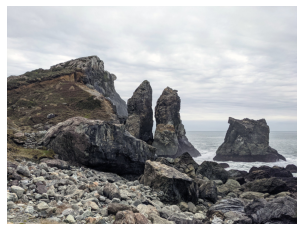

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

**사전 훈련된 `InceptionV3` 모델 로드하기**

In [2]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [3]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                    

**딥드림 손실에 대한 각 층의 기여도 설정하기**

In [4]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [6]:
outputs_dict

{'mixed4': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed4')>,
 'mixed5': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>,
 'mixed6': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed6')>,
 'mixed7': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed7')>}

In [8]:
outputs_dict2 = {name:model.get_layer(name).output for name in layer_settings.keys()}
outputs_dict2

{'mixed4': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed4')>,
 'mixed5': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>,
 'mixed6': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed6')>,
 'mixed7': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed7')>}

**딥드림 손실**

여기서는 손실을 줄이는 방향이 아니라 키우는  방향으로 학습을 하기 때문에 손실보다는 gain으로 이해하는 것이 좋다.

In [9]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=()) # zero value scalar tensor
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name] # (1, l.h, l.w, l.c)
        # zero-padding을 거친 컨볼루션의 가장자리는 정보량이 적고,거친 이미지라서 제외
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

**딥드림 경사 상승법 단계**

In [10]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        # watch: tf.Variable이 아닌 tf.Constant를 업데이트하도록 해줌
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... 스텝 {i}에서 손실 값: {loss:.2f}")
    return image

In [11]:
step = 20. # learning rate
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

**이미지 처리 유틸리티**

아래 함수들은 deep dream 구현을 위한 유틸리티 함수들입니다:
- resize_img: zoom을 이용하여 주어진 size의 shape으로 이미지의 (H, W)를 변환합니다.
- preprocess_image: inceptionV3가 요구하는 [-1, 1] 범위의 픽셀값을 갖는 array 이미지로 변환합니다.
- deprocess_image: inception_v3.preprocess_input 함수에서 수행한 전처리 과정을 복원하여 PIL 이미지의 array로 변환합니다.
- save_img: 변형된 이미지를 deprocess_image 함수를 이용해 RGB 포맷의 PIL 이미지로 변환하여 저장합니다.

In [12]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path) # PIL type image
    img = keras.utils.img_to_array(img)    # numpy image
    img = np.expand_dims(img, axis=0)      # 1batch images
    img = keras.applications.inception_v3.preprocess_input(img) # (350,350,3) [-1, 1]
    return img

# (1, h, w, c) in [-1,1] => (h, w, c) in [0,255]
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3)) # (1,h,w,c) =< (h,w,c) in [-1,1]
    img += 1.0      # [0, 2]
    img *= 127.5    # [0, 255]
    img = np.clip(img, 0, 255).astype("uint8") # to numpy image in [0, 255]
    return img

**연속적인 여러 개의 “옥타브"에 걸쳐 경사 상승법 실행하기**

In [15]:
original_img = preprocess_image(base_image_path) # (1,900,1200,3) in [-1,1]
# original_img.shape
original_shape = original_img.shape[1:3]         # (900,1200)

successive_shapes = [original_shape]  # [(900,1200), (642,857), (459,612)]
for i in range(1, num_octave):
    # shape = (642,857) @ i=1, (459,612) @ i=2
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1] # [(459,612), (642,857), (900,1200)]

# (459,612)
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

# tf.identity: 변수 텐서의 값을 복사한 일시적인 상수 텐서
img = tf.identity(original_img) # (900,1200)
for i, shape in enumerate(successive_shapes):
    print(f"{shape} 크기의 {i}번째 옥타브 처리")
    img = tf.image.resize(img, shape) # (459,612), deep dreamed imag add detail and upscale to (642,857)=>(900,1200)
    # deep dreamed img
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape) # (459,612)=>(642,857)=>(900,1200), 작은것을 키운 것
    same_size_original = tf.image.resize(original_img, shape) # (459,612), (642,857), (900,1200), 큰것을 작게한 것
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail # deep dreamed img add detail
    shrunk_original_img = tf.image.resize(original_img, shape) # (459,612), (642,857), 큰것을 작게한 것

# (1, h, w, c) in [-1,1] => (h, w, c) in [0,255]
keras.utils.save_img("dream.png", deprocess_image(img.numpy()))

(459, 612) 크기의 0번째 옥타브 처리
... 스텝 0에서 손실 값: 0.80
... 스텝 1에서 손실 값: 1.07
... 스텝 2에서 손실 값: 1.44
... 스텝 3에서 손실 값: 1.82
... 스텝 4에서 손실 값: 2.17
... 스텝 5에서 손실 값: 2.48
... 스텝 6에서 손실 값: 2.84
... 스텝 7에서 손실 값: 3.19
... 스텝 8에서 손실 값: 3.57
... 스텝 9에서 손실 값: 3.93
... 스텝 10에서 손실 값: 4.28
... 스텝 11에서 손실 값: 4.62
... 스텝 12에서 손실 값: 4.98
... 스텝 13에서 손실 값: 5.33
... 스텝 14에서 손실 값: 5.69
... 스텝 15에서 손실 값: 6.05
... 스텝 16에서 손실 값: 6.41
... 스텝 17에서 손실 값: 6.72
... 스텝 18에서 손실 값: 7.08
... 스텝 19에서 손실 값: 7.37
... 스텝 20에서 손실 값: 7.72
... 스텝 21에서 손실 값: 8.04
... 스텝 22에서 손실 값: 8.34
... 스텝 23에서 손실 값: 8.61
... 스텝 24에서 손실 값: 8.92
... 스텝 25에서 손실 값: 9.21
... 스텝 26에서 손실 값: 9.52
... 스텝 27에서 손실 값: 9.81
... 스텝 28에서 손실 값: 10.05
... 스텝 29에서 손실 값: 10.35
(642, 857) 크기의 1번째 옥타브 처리
... 스텝 0에서 손실 값: 1.60
... 스텝 1에서 손실 값: 2.64
... 스텝 2에서 손실 값: 3.44
... 스텝 3에서 손실 값: 4.04
... 스텝 4에서 손실 값: 4.57
... 스텝 5에서 손실 값: 5.03
... 스텝 6에서 손실 값: 5.51
... 스텝 7에서 손실 값: 5.95
... 스텝 8에서 손실 값: 6.34
... 스텝 9에서 손실 값: 6.72
... 스텝 10에서 손실 값: 7.15
... 스텝 11에서 손실 값: 7.49


In [21]:
from IPython.display import Image
Image('dream.png')

Output hidden; open in https://colab.research.google.com to view.

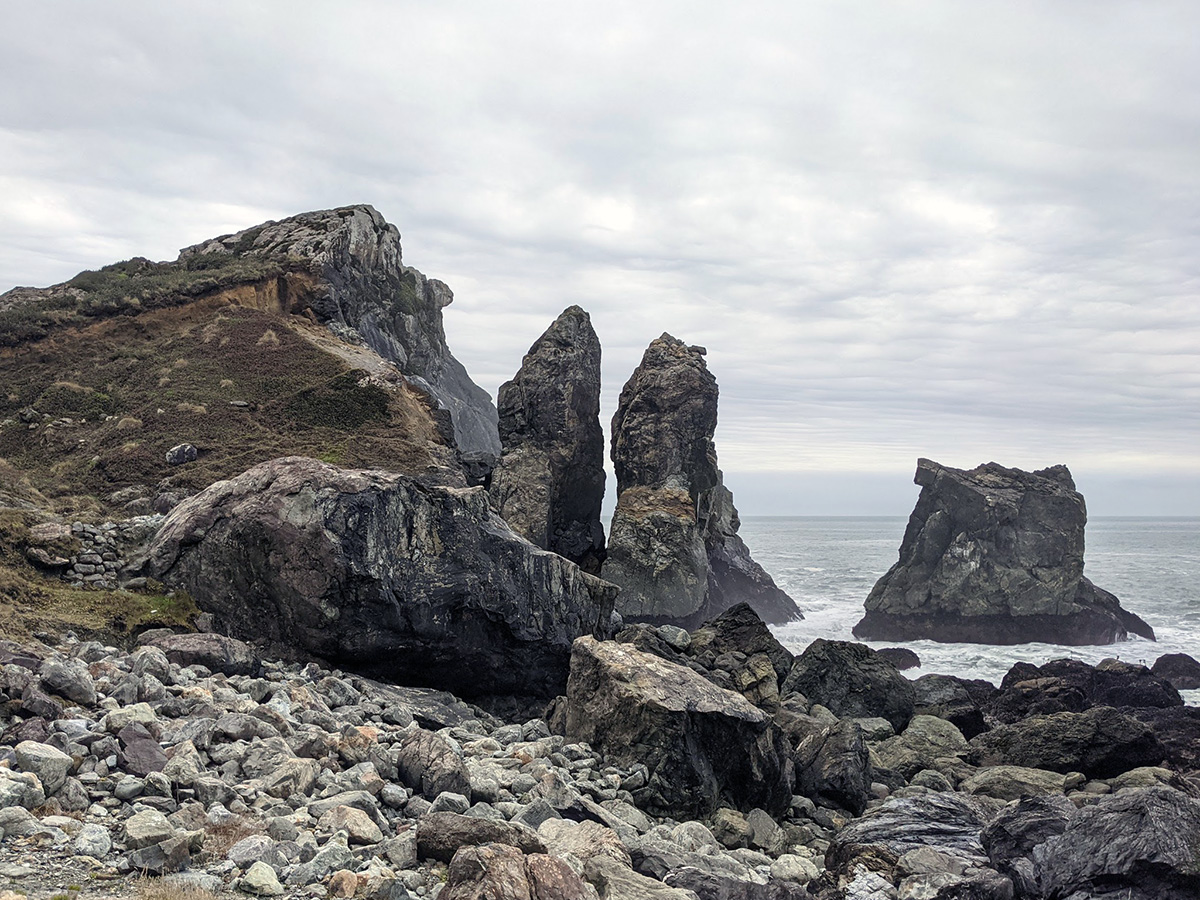

In [23]:
from IPython.display import Image
Image('https://img-datasets.s3.amazonaws.com/coast.jpg')

### 정리
- 모델을 달리하거나
- layer를 달리하거나
- layer 가중치를 달리하거나
- octave scale과 num octave를 달리하거나
- max_loss나 step, iterations를 달리하거나